## TLC Data Lab

TLC: Taxi and Limousine commission provides open data for yellow taxis, FHV, shared FHV and green taxis for NYC. Data includes information about each trip containing pick up and drop off times, fare information, number of passengers, miles traveled etc.

### Objectives

- Cleaning the data - filtering out the outliers and trips with unreasonable parameters
- Explore spatial and temporal data distribution of the number of trips, distances etc, fares and the travel speed.
- Practice spatial mapping with geopandas

### Skills

- Data cleaning and sanity checks
- convert non-spatial data to spatial with geopandas
- visualizing data on the maps

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import urllib
import sys
from matplotlib import pyplot as plt
%matplotlib inline

/Users/devashishkhulbe/opt/anaconda3/envs/py39/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


Downloading TLC yellow taxi data January 2019

In [2]:
#download the file - notice an alternative way of doing so through 
#a command line unix command curl, retreaving the data with progress tracking
#takes up to 5min on fast internet connection
!curl https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-01.csv > yellow_trips_19.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 12  655M   12 85.1M    0     0  4671k      0  0:02:23  0:00:18  0:02:05 5833k    0     0  4540k      0  0:02:27  0:00:16  0:02:11 5864k^C


In [3]:
# alternate way of downloading file thorugh urllib, the first argument is the link, 
# second is the name you want to give to the file 
urllib.request.urlretrieve ("https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-01.csv", "yellow_trips_19_1.csv")

In [4]:
#upload the data; the file is big, so takes some time, under a minute
data = pd.read_csv('yellow_trips_19.csv', parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.5,1,N,151,239,1,7.0,0.5,0.5,1.65,0.0,0.3,9.95,NaN
1,1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.6,1,N,239,246,1,14.0,0.5,0.5,1.00,0.0,0.3,16.30,NaN
2,2,2018-12-21 13:48:30,2018-12-21 13:52:40,3,0.0,1,N,236,236,1,4.5,0.5,0.5,0.00,0.0,0.3,5.80,NaN
3,2,2018-11-28 15:52:25,2018-11-28 15:55:45,5,0.0,1,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,7.55,NaN
4,2,2018-11-28 15:56:57,2018-11-28 15:58:33,5,0.0,2,N,193,193,2,52.0,0.0,0.5,0.00,0.0,0.3,55.55,NaN


'PULocationID' and 'DOLocationID' are the pick up and drop off taxi zones. 'fare_amount' is the trip cost, 'trip_distance' is the distance of the trip in miles. We will analyze the trips by travel duration, cost, distances and speed.

In [5]:
data.dtypes #get the column names with types

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int64
trip_distance                   float64
RatecodeID                        int64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
dtype: object

### creating a column for travel time in minutes

In [6]:
data['trip_duration'] = (data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime'])
data['trip_duration'] = data['trip_duration'].dt.total_seconds()/60
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,trip_duration
0,1,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.5,1,N,151,239,1,7.0,0.5,0.5,1.65,0.0,0.3,9.95,NaN,6.666667
1,1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.6,1,N,239,246,1,14.0,0.5,0.5,1.00,0.0,0.3,16.30,NaN,19.200000
2,2,2018-12-21 13:48:30,2018-12-21 13:52:40,3,0.0,1,N,236,236,1,4.5,0.5,0.5,0.00,0.0,0.3,5.80,NaN,4.166667
3,2,2018-11-28 15:52:25,2018-11-28 15:55:45,5,0.0,1,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,7.55,NaN,3.333333
4,2,2018-11-28 15:56:57,2018-11-28 15:58:33,5,0.0,2,N,193,193,2,52.0,0.0,0.5,0.00,0.0,0.3,55.55,NaN,1.600000


### creating column for average travel speed (mph)

In [7]:
data['speed'] = data['trip_distance']/(data['trip_duration']/60)

### check some basic statistics

In [8]:
data[['trip_distance', 'trip_duration', 'fare_amount', 'speed']].describe()

,trip_distance,trip_duration,fare_amount,speed
count,7.667792e+06,7.667792e+06,7.667792e+06,7.661824e+06
mean,2.801084e+00,1.648122e+01,1.240941e+01,inf
std,3.737529e+00,8.181505e+01,2.620721e+02,NaN
min,0.000000e+00,-8.428050e+04,-3.620000e+02,-4.016583e-02
25%,9.000000e-01,6.100000e+00,6.000000e+00,7.586553e+00
50%,1.530000e+00,1.015000e+01,8.500000e+00,1.008621e+01
75%,2.800000e+00,1.656667e+01,1.350000e+01,1.373333e+01
max,8.318000e+02,4.364802e+04,6.232599e+05,inf


The total number of records is approximately 7.7M. 

But we can notice all kinds of issues including zero trip distances, negative durations and fare amounts as well fares, extra high distances, durations and fares as well as resulting negative, NaN and infinite speeds (due to travel time 0 or both travel time and distance 0).

So some data cleaning is required

Removing the trips with duration 0

In [9]:
sum(data.trip_duration <= 0) #number of trips with non-positive duration

6294

In [10]:
sum(data.fare_amount <= 0) #number of trips with non-positive fare amount

9557

In [11]:
sum(data.trip_distance <= 0) #number of trips with non-positive distance

54770

In [12]:
validind = (data.trip_duration > 0) & (data.trip_distance > 0) & (data.fare_amount > 0) #index of valid trips

In [13]:
sum(~validind) #total number of invalid trips

61680

In [14]:
#filter the data - positive duration, distance, fare amount
data = data[validind]

In [15]:
#recompute the statistics
data[['trip_distance', 'trip_duration', 'fare_amount', 'speed']].describe()

,trip_distance,trip_duration,fare_amount,speed
count,7.606112e+06,7.606112e+06,7.606112e+06,7.606112e+06
mean,2.821921e+00,1.659043e+01,1.226454e+01,1.322520e+01
std,3.741116e+00,7.536785e+01,2.262769e+02,1.375292e+02
min,1.000000e-02,1.666667e-02,1.000000e-02,4.190188e-04
25%,9.200000e-01,6.166667e+00,6.000000e+00,7.636364e+00
50%,1.550000e+00,1.021667e+01,9.000000e+00,1.012048e+01
75%,2.820000e+00,1.661667e+01,1.350000e+01,1.376771e+01
max,8.318000e+02,4.364802e+04,6.232599e+05,7.344000e+04


In [16]:
#now the values are formally valid, but we still see unreasonably small and large values for either quantity

### check the distributions for these variables

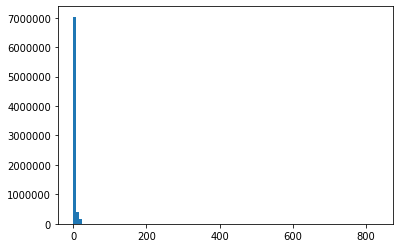

In [17]:
#uniform scale histogram for trip distance does not tell much
n_bins = 100
plt.hist(data.trip_distance, bins=n_bins);

log-scale histogram

In [18]:
def plot_loghist(x, bins): #introduce a function for plotting a log-scale histogram
  #it ensures log-scale binning and label on the original scale
    logbins = np.logspace(np.log10(x.min()),np.log10(x.max()),bins)
    plt.hist(x, bins=logbins)
    plt.xscale('log')

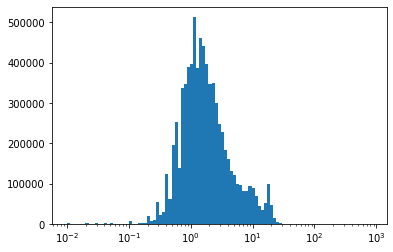

In [19]:
plot_loghist(data.trip_distance, 100)

most of the trips are within 0.2 and 20 miles

In [20]:
#use box plot for more detail on the quantiles

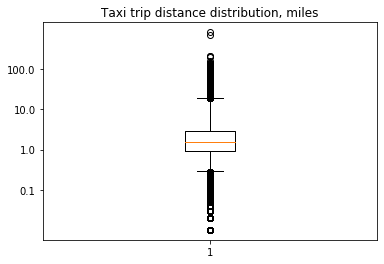

In [21]:
ax = plt.subplot(1, 1, 1)
ax.boxplot(np.log10(data.trip_distance), whis=[1, 99]) #box plot of the log trip_distance with 1 and 99 percentiles and the outliers beyond them
ax.set_yticks(np.arange(-1, 3))
ax.set_yticklabels(10.0**np.arange(-1, 3, 1))
ax.set_title('Taxi trip distance distribution, miles')
plt.show()

In [22]:
#Exact 1% percetile
data.trip_distance.quantile(0.01)

0.29

In [23]:
#Exact 99% percetile
data.trip_distance.quantile(0.99)

18.9

So while 98% of the trips are within around 0.3-19 miles, some are too short (<0.3 mile) others too long; perpahs trips over 20miles are still possible but those >100miles look unrealistic for NYC (those would be 2.5times the driving distance between Staten Island, northern Bronx or EWR (included in the analysis) and JFK or Far Rockaways, which is around 40miles).

check number of trips with high distance (100 miles)

In [24]:
len(data[data.trip_distance > 100])

30

distribution for speed

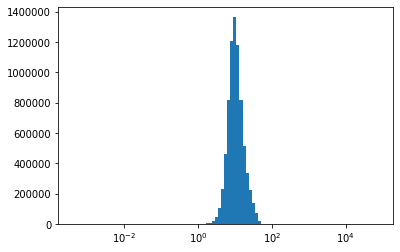

In [25]:
plot_loghist(data.speed, 100)

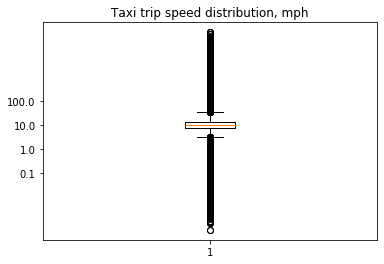

In [26]:
ax = plt.subplot(1, 1, 1)
ax.boxplot(np.log10(data.speed), whis=[1, 99]) #box plot of the log speed with 1 and 99 percentiles and the outliers beyond them
ax.set_yticks(np.arange(-1, 3))
ax.set_yticklabels(10.0**np.arange(-1, 3, 1))
ax.set_title('Taxi trip speed distribution, mph')
plt.show()

In [27]:
data.speed.quantile(0.01)

3.126550868486352

In [28]:
data.speed.quantile(0.99)

36.02623276967928

We can use 1% percentile for lower oulier filtering (all those trips are slower than relaxed walk on average). For upper outliers take the max speed limit of 65mph and add 15mph on top as the vehicle might be speeding, but perhaps not all the time.

In [29]:
len(data[data.speed > 80]) #number of trips with unreasonably high speed

5938

trip duration distribution

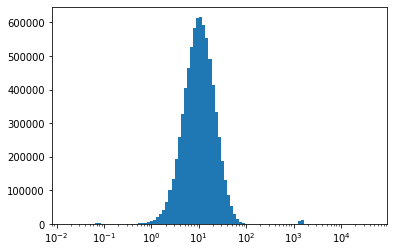

In [30]:
plot_loghist(data.trip_duration, 100)

we see some trips with extreme duration - less than 1minute or more than 1000 minutes. Set the range as 1-100 minutes max

In [31]:
len(data[data.trip_duration > 100]) #number of ourliers

21538

In [32]:
len(data[data.trip_duration < 1])

28955

fare amount distributions

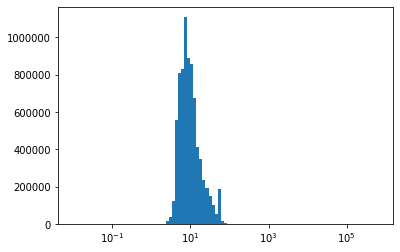

In [33]:
plot_loghist(data.fare_amount, 100)

In [34]:
data.fare_amount.quantile(0.99)

52.0

In [35]:
#The top 1% of the fares start at $52, although there is some unusual spike around that number - worth investigating, might be some data artifact

In [36]:
#for now let's just impose some meaningful range 

In [37]:
len(data[data.fare_amount > 300]) #extremely high fares

82

In [38]:
len(data[data.fare_amount < 2.5]) #fares below initial charge

392

In [39]:
#based on the above impose the data sanity index
sanityindex = (data.fare_amount >= 2.5) & (data.fare_amount <= 300) & \
    (data.trip_distance >= 0.3) & (data.trip_distance <= 100) & \
    (data.speed <= 80) & (data.speed >= 2) & \
    (data.trip_duration <= 100) & (data.trip_duration >= 1)

In [40]:
sum(~sanityindex) #another 111k trips to be discarded

111661

### filter out trips with unreasonable values of distance, time, speed and fares

In [41]:
data = data[sanityindex]
data.shape #still 7.5M trips survive

(7494451, 20)

check distribution now

In [42]:
data[['trip_distance', 'trip_duration', 'fare_amount', 'speed']].describe()

,trip_distance,trip_duration,fare_amount,speed
count,7.494451e+06,7.494451e+06,7.494451e+06,7.494451e+06
mean,2.842623e+00,1.301125e+01,1.220449e+01,1.175560e+01
std,3.700714e+00,9.847805e+00,1.059132e+01,6.312856e+00
min,3.000000e-01,1.000000e+00,2.500000e+00,2.000000e+00
25%,9.500000e-01,6.283333e+00,6.000000e+00,7.696793e+00
50%,1.570000e+00,1.028333e+01,9.000000e+00,1.016129e+01
75%,2.850000e+00,1.663333e+01,1.350000e+01,1.379221e+01
max,9.613000e+01,9.995000e+01,3.000000e+02,8.000000e+01


In [43]:
# let's save this cleaned file #also takes some time up to a couple of min
data.to_csv('yellowTaxi_cleaned.csv', index=False)

### Spatial filtering - filtering trips originating and ending within NYC

### we will use NYC taxi zone data for filtering

In [44]:
#upload the shapefile; The 'location_i' column consists of all taxi zones within NYC + Newark airport
taxi = gpd.read_file('https://data.cityofnewyork.us/api/geospatial/d3c5-ddgc?method=export&format=Shapefile')
taxi.head()

,borough,location_i,objectid,shape_area,shape_leng,zone,geometry
0,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
1,Queens,2.0,2.0,0.004866,0.433470,Jamaica Bay,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,Bronx,3.0,3.0,0.000314,0.084341,Allerton/Pelham Gardens,"POLYGON ((-73.84793 40.87134, -73.84725 40.870..."
3,Manhattan,4.0,4.0,0.000112,0.043567,Alphabet City,"POLYGON ((-73.97177 40.72582, -73.97179 40.725..."
4,Staten Island,5.0,5.0,0.000498,0.092146,Arden Heights,"POLYGON ((-74.17422 40.56257, -74.17349 40.562..."


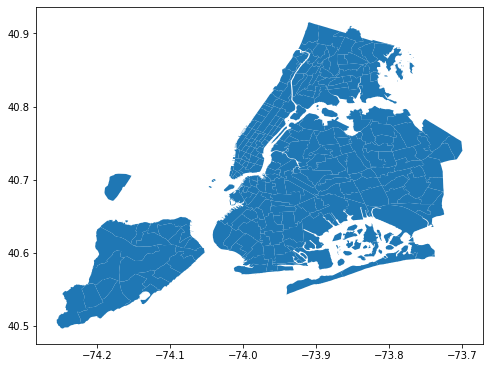

In [45]:
taxi.plot(figsize=(8,8))

### check number of pickup location and drop off location ID from data which lies outside taxi zone codes

In [46]:
len(data[~data.PULocationID.isin(taxi.location_i)])

149336

In [47]:
len(data[~data.DOLocationID.isin(taxi.location_i)])

151649

### keep trips which start and end in NYC + Newark airport

In [48]:
data = data[(data.PULocationID.isin(taxi.location_i)) & (data.DOLocationID.isin(taxi.location_i))]
data.shape                                               

(7327504, 20)

## Spatial distribution of the taxi activity

In [49]:
#get the number of trips by taxi zone of origin
tripsByZone = data.groupby(by='PULocationID', as_index=False).count()[['PULocationID', 'DOLocationID']]
tripsByZone.rename(columns={'DOLocationID':'N_trips'}, inplace=True)
tripsByZone.head()

,PULocationID,N_trips
0,1,20
1,2,10
2,3,157
3,4,13613
4,5,3


### plot the number of trips per taxi zone on a NYC map

merge with taxi zone shapefile first

In [50]:
tripsViz = taxi.merge(tripsByZone, left_on='location_i', right_on='PULocationID')
tripsViz.head()

,borough,location_i,objectid,shape_area,shape_leng,zone,geometry,PULocationID,N_trips
0,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...",1,20
1,Queens,2.0,2.0,0.004866,0.433470,Jamaica Bay,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...",2,10
2,Bronx,3.0,3.0,0.000314,0.084341,Allerton/Pelham Gardens,"POLYGON ((-73.84793 40.87134, -73.84725 40.870...",3,157
3,Manhattan,4.0,4.0,0.000112,0.043567,Alphabet City,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...",4,13613
4,Staten Island,5.0,5.0,0.000498,0.092146,Arden Heights,"POLYGON ((-74.17422 40.56257, -74.17349 40.562...",5,3


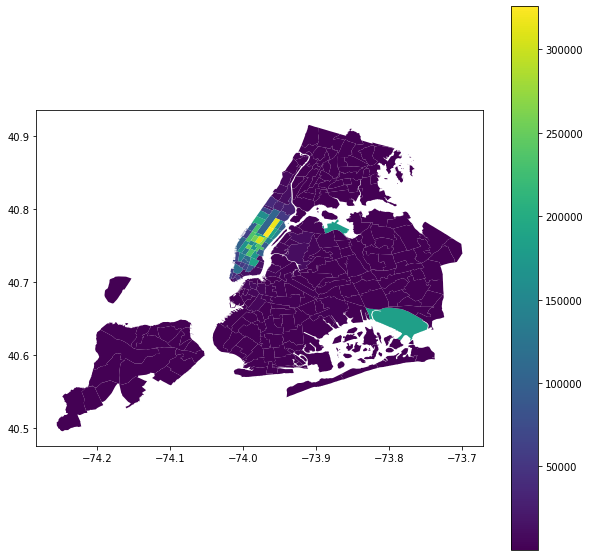

In [51]:
tripsViz.plot(figsize=(10,10), column='N_trips', legend=True)

### too many trips are concentrated in Manhattan and JFK, Laguardia airports as compared to other areas. This way those areas completely doninate the colormap. A better way to visualize might be to split the activity in quantiles and assign colors to quantiles

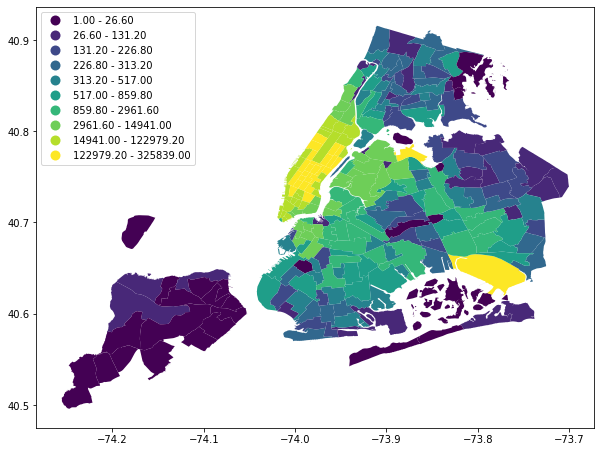

In [52]:
fig, ax = plt.subplots(1, figsize=(10,10))

tripsViz.plot(ax=ax, column='N_trips', k=10, scheme='Quantiles', legend=True, 
              legend_kwds={'loc': 'upper left'})


### One important issue to mind with visualizing aggregated activity is the homogeniety of spatial units
Right now taxi zones are all of different size, while the activity heatmap is usually perceived as a density map. However the quantity above is affected by both - activity density as well as the size of the unit which is somewhat arbitrary. Normalizing activity by the area (trips per sq. mile) or by population (trips per capita) would be more appropriate

In [53]:
tripsViz['ActivityDensity'] = tripsViz['N_trips'] / tripsViz['shape_area']

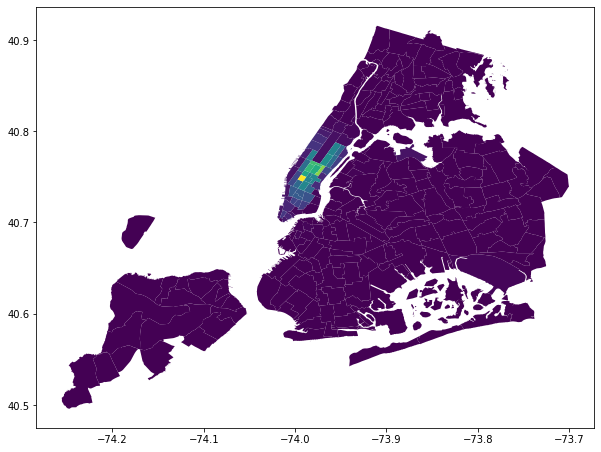

In [69]:
#consider density heatmap without percentiles first 
tripsViz.plot(figsize = (10,10), column='ActivityDensity', legend=False)

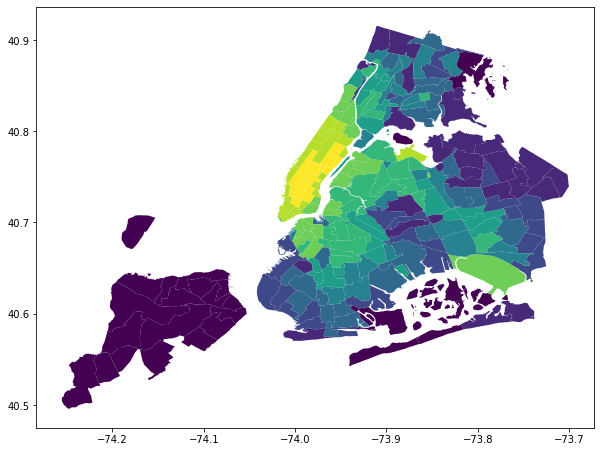

In [70]:
#now by percentile 
tripsViz.plot(figsize = (10,10), column='ActivityDensity', scheme='Quantiles', k=10, legend=False)

## Explore temporal distribution of taxi ridership activity
Assess how the number of trips varies with the time of the day

make a column for pickup hour - 0-23 hrs (0 corresponds to 12am-1am window, 1 to 1am-2am window and so on...)

In [55]:
data['pickUpHour'] = data['tpep_pickup_datetime'].dt.hour
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,trip_duration,speed,pickUpHour
0,1,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.5,1,N,151,239,1,...,0.5,0.5,1.65,0.0,0.3,9.95,NaN,6.666667,13.500000,0
1,1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.6,1,N,239,246,1,...,0.5,0.5,1.00,0.0,0.3,16.30,NaN,19.200000,8.125000,0
7,1,2019-01-01 00:21:28,2019-01-01 00:28:37,1,1.3,1,N,163,229,1,...,0.5,0.5,1.25,0.0,0.3,9.05,NaN,7.150000,10.909091,0
8,1,2019-01-01 00:32:01,2019-01-01 00:45:39,1,3.7,1,N,229,7,1,...,0.5,0.5,3.70,0.0,0.3,18.50,NaN,13.633333,16.283619,0
9,1,2019-01-01 00:57:32,2019-01-01 01:09:32,2,2.1,1,N,141,234,1,...,0.5,0.5,1.70,0.0,0.3,13.00,NaN,12.000000,10.500000,0


In [56]:
#group trips by hour
tripsByHour = data[['pickUpHour', 'DOLocationID']].groupby(by='pickUpHour', as_index=False).count()
tripsByHour.rename(columns={'DOLocationID':'N_trips'}, inplace=True)
tripsByHour

,pickUpHour,N_trips
0,0,197815
1,1,141615
2,2,103406
3,3,73298
4,4,56983
5,5,70235
6,6,168205
7,7,289721
8,8,356084
9,9,348450


let's visualize number of trips by hour on a bar plot

Text(0.5, 0, 'hour of day')

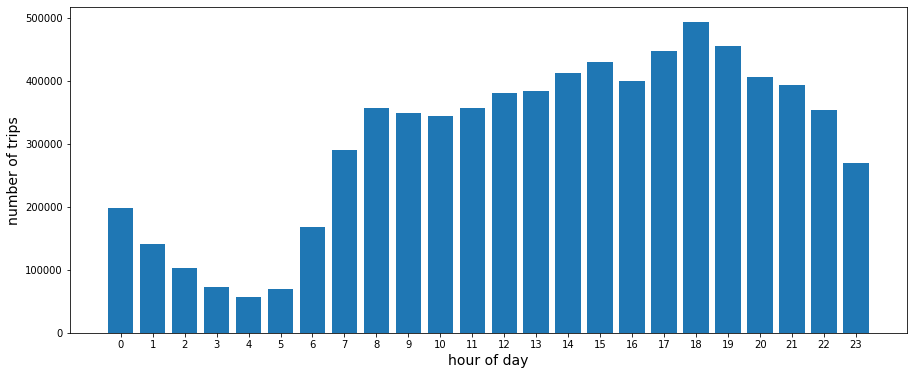

In [57]:
plt.figure(figsize=(15, 6))

plt.bar(tripsByHour.pickUpHour, tripsByHour.N_trips)
plt.xticks(tripsByHour.pickUpHour)
plt.ylabel('number of trips', fontsize=14)
plt.xlabel('hour of day', fontsize=14)

## Explore average travel speed by hour of the day

In order to homogenize by traffic mileage we use the distance total/duration total instead of averaging individual trip speed

In [58]:
speedByHour = data[['pickUpHour', 'trip_distance', 'trip_duration']].groupby(by='pickUpHour', as_index=False).sum()
speedByHour['speed'] = speedByHour['trip_distance'] / speedByHour['trip_duration'] * 60
speedByHour

,pickUpHour,trip_distance,trip_duration,speed
0,0,668410.54,2.402033e+06,16.696120
1,1,448643.09,1.641700e+06,16.396774
2,2,314800.97,1.151758e+06,16.399331
3,3,241568.85,8.203392e+05,17.668460
4,4,234763.94,6.724771e+05,20.946194
5,5,305578.01,7.991807e+05,22.941845
6,6,546404.99,1.842141e+06,17.796851
7,7,809275.36,3.595500e+06,13.504803
8,8,898508.65,4.857460e+06,11.098499
9,9,864949.05,4.779206e+06,10.858905


Text(0.5, 0, 'hour of day')

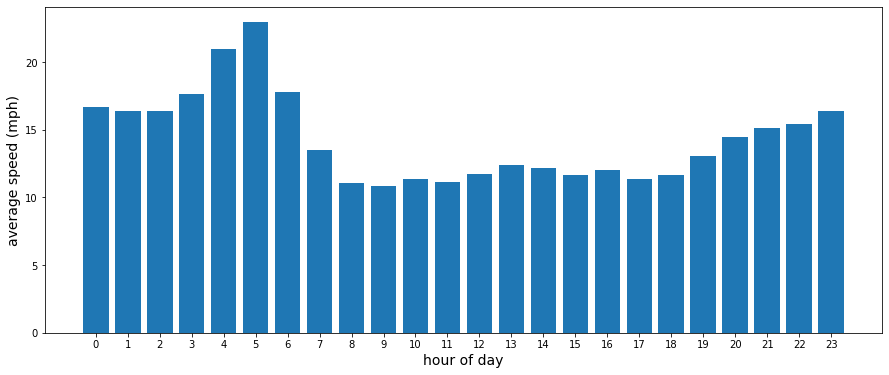

In [59]:
plt.figure(figsize=(15, 6))

plt.bar(speedByHour.pickUpHour, speedByHour.speed)
plt.xticks(speedByHour.pickUpHour)
plt.ylabel('average speed (mph)', fontsize=14)
plt.xlabel('hour of day', fontsize=14)

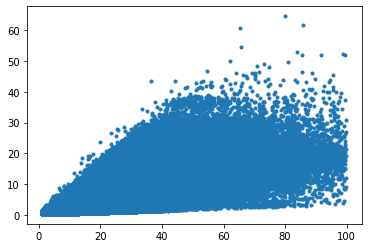

In [67]:
#also see how heterogenous is the travel speed accross the sample 
#by exploring relation between travel distances vs travel times over the entire sample
#use a scatter plot #takes a few seconds to generate
plt.plot(data['trip_duration'],data['trip_distance'],'.')

## Homework tasks

1. Explore spatial distribution of average travel speed and total trip distance by pick up location and visualize on a map

Hint: for average speed a normal color map should be okay while for total distance you might consider quantiles viz.

In [60]:
## code here,

2. Plot travel density by drop off location

Use area normalization, quantile visualization as before but this time aggregte activity by drop off taxi zone

3. Explore total number of trips, average speed and total distance by day of the week and visualize in a bar plot

In [61]:
# make a column for day of week


In [62]:
# group by for getting metrics, remember 'count()' for number of trips, 'mean()' for average and 'sum()' 
# for getting total 


In [63]:
# make a bar plot


4. Identify and visualize the top 10 and botton 10 areas by largest trip density, average speed and average distance (grouped by origin) 

In [64]:
## spatial visualization here